# Load dataset

In [1]:
import numpy as np

In [2]:
xy = np.load("openface_and_labels_by_frame.npz")
X, y = xy["x"], xy["y"]

In [3]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (604901, 713)
y shape: (604901, 7)


In [4]:
print(X[1].shape)

(713,)


# Exploration of data

In [5]:
X_sample = X[np.random.choice(len(X))]
y_sample = y[np.random.choice(len(y))]
print("random X min:", np.min(X_sample))
print("random X max:", np.max(X_sample))
print("random y min:", np.min(y_sample))
print("random y max:", np.max(y_sample))

random X min: -143.65
random X max: 716.5222
random y min: 0.0
random y max: 0.6666667


In [6]:
print("x min:", np.min(X))
print("x max:", np.max(X))

x min: -34065332.0
x max: 48234530.0


In [7]:
def summarize_y(y):
    for i in range(y.shape[1]):
        print("min y, index", i, ":", np.min(y[:,i]))
        print("max y, index", i, ":", np.max(y[:,i]), "\n")

    print("y min:", np.min(y[:,4]))
    print("y max:", np.max(y))
    print("y mean:", np.mean(y))
    print("y std:", np.std(y), "\n")

In [8]:
summarize_y(y)

min y, index 0 : -3.0
max y, index 0 : 3.0 

min y, index 1 : 0.0
max y, index 1 : 3.0 

min y, index 2 : 0.0
max y, index 2 : 3.0 

min y, index 3 : 0.0
max y, index 3 : 3.0 

min y, index 4 : 0.0
max y, index 4 : 3.0 

min y, index 5 : 0.0
max y, index 5 : 3.0 

min y, index 6 : 0.0
max y, index 6 : 1.6666666 

y min: 0.0
y max: 3.0
y mean: 0.17889453
y std: 0.56088483 



Note: per the paper, the integral [-3, 3] for the target values, as implied above (min/max) represents sentiment, with +3 being highly positive, -3 highly negative, 0 neutral. the mean value is also consistent with the distribution shown in the paper (pp 2240 fig 2), which shows that most annotations are neutral or weakly positive (0-1). do we need to balance the classes at some point? **note that the first index (i=0) of any given target array represents this integral.

The paper mentions a second integral [0,3] which measures the presence of emotion (0 = no presence, 3 = highest presence). It looks like indices 1-5 of the target arrays are of this integral.

In [9]:
np.unique(y[:,1])

array([0.        , 0.16666667, 0.33333334, 0.5       , 0.6666667 ,
       0.8333333 , 1.        , 1.1666666 , 1.3333334 , 1.6666666 ,
       2.        , 2.1666667 , 2.3333333 , 2.6666667 , 3.        ],
      dtype=float32)

Note: it looks like the values are specifically sixths (1/6) between the intervals I specified above for each of the 7 labels. once I was sure of this, I went ahead and converted them to integer representations.

In [10]:
y_encoded = y * 6
np.unique(y_encoded)

array([-18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -3.,  -2.,  -1.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  18.], dtype=float32)

In [11]:
y_encoded = np.round(y_encoded).astype(np.int64)

In [12]:
summarize_y(y_encoded)

min y, index 0 : -18
max y, index 0 : 18 

min y, index 1 : 0
max y, index 1 : 18 

min y, index 2 : 0
max y, index 2 : 18 

min y, index 3 : 0
max y, index 3 : 18 

min y, index 4 : 0
max y, index 4 : 18 

min y, index 5 : 0
max y, index 5 : 18 

min y, index 6 : 0
max y, index 6 : 10 

y min: 0
y max: 18
y mean: 1.0733673774716854
y std: 3.365308890115125 



y mean: 1.0511714589109071
y std: 2.3889861170909072 



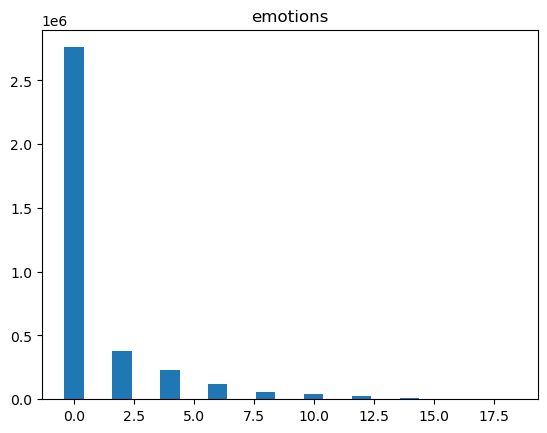

y mean: 1.206542888836355
y std: 6.709165954547927 



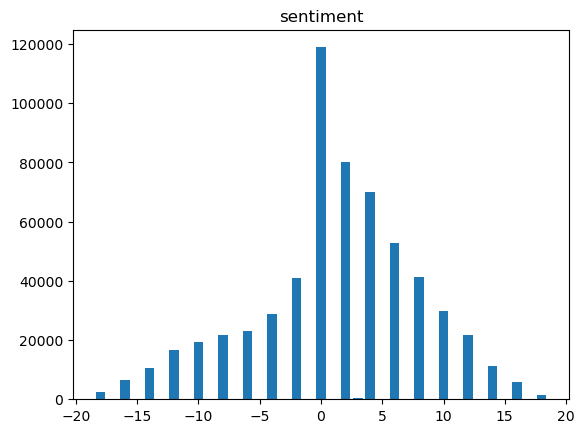

In [14]:
plot_values(y_encoded[:,1:], "emotions")
plot_values(y_encoded[:,0], "sentiment")

## Data visualization to understand any imbalances/other issues with dataset

In [13]:
import matplotlib.pyplot as plt

def plot_values(data, title):
    values, counts = np.unique(data, return_counts=True)
    print("y mean:", np.mean(data))
    print("y std:", np.std(data), "\n")
    plt.bar(values, counts)
    plt.title(title)
    plt.show()

y mean: 3.0390047941808565
y std: 3.804901894615814 



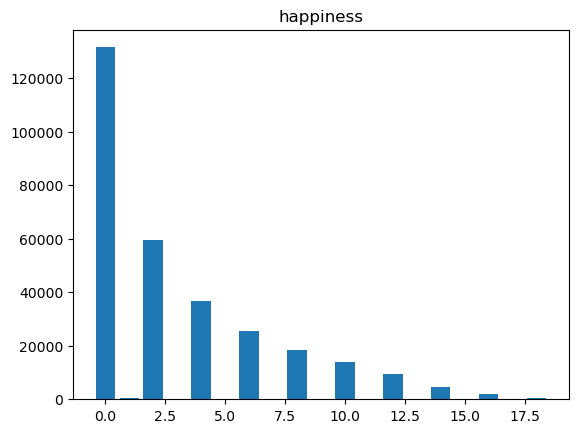

y mean: 0.9826814349479253
y std: 1.9597312285618538 



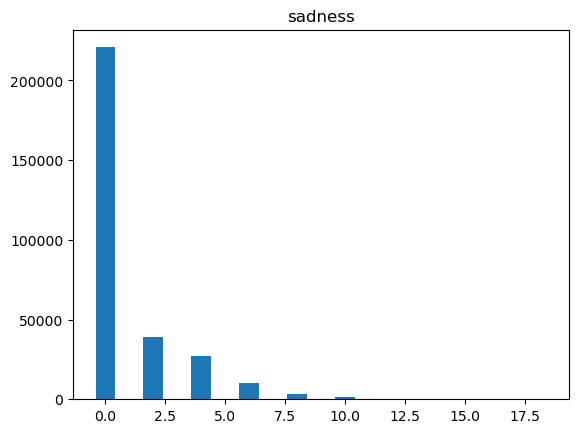

y mean: 0.9379269300710862
y std: 2.1806909291251797 



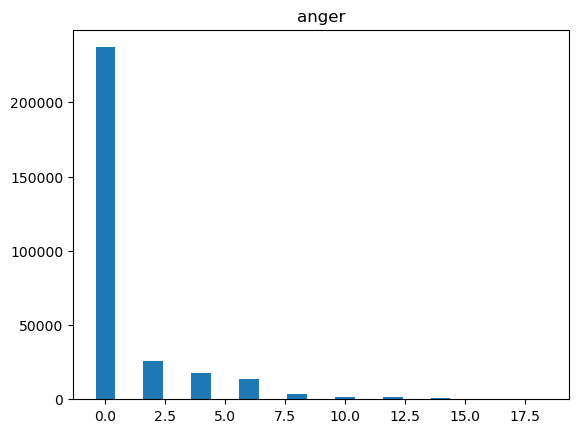

y mean: 0.3169416432468177
y std: 1.0613099810674471 



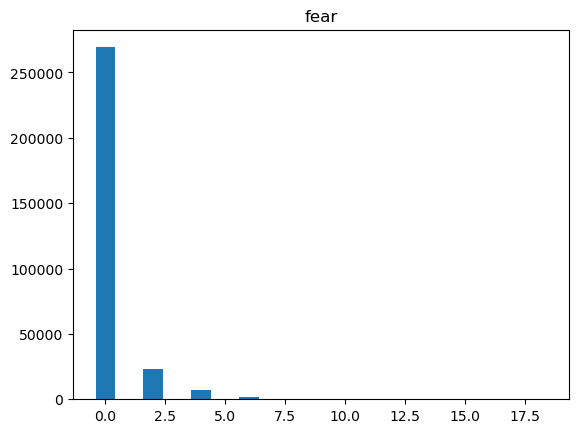

y mean: 0.729816498594809
y std: 1.964751726399561 



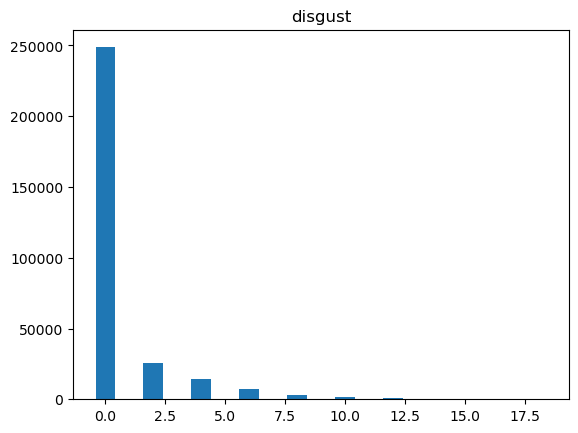

y mean: 0.31397586377913705
y std: 1.032896221382137 



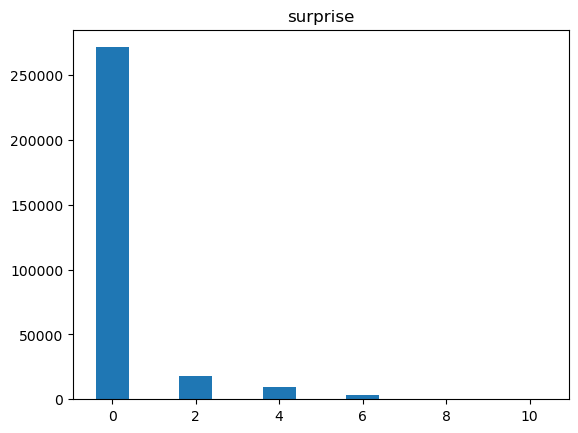

In [19]:
plot_values(y_happiness, "happiness")
plot_values(y_sadness, "sadness")
plot_values(y_anger, "anger")
plot_values(y_fear, "fear")
plot_values(y_disgust, "disgust")
plot_values(y_surprise, "surprise")

In [20]:
# from cv2 import VideoCapture
# import matplotlib.pyplot as plt

# cam_port = 10
# cam = VideoCapture(cam_port)

# result, capture = cam.read()

# plt.imshow(capture)

# Split data

We can decide later exactly how much of the data ought to be used, but for the sake of testing things for now, I've truncated the dataset to something more manageable from a time perspective (sample a number (n_samples * m_percent) of random indices and extract those indices from the features/targets). I can perform a larger-in-scale training session over break on my GPU desktop (hopefully without interruption due to hardware limitations) once we're satisfied with the model parameterization

In [15]:
def truncate_data(X, y, pct_samples):
    if pct_samples == 1:
        return X, y
    else:
        random_i = np.random.choice(len(X), size = pct_samples)
        X_trunc = X[random_i]
        y_trunc = y[random_i]
        print("X:", X_trunc.shape, "|", "y:", y_trunc.shape)
        return X_trunc, y_trunc

In [16]:
# happiness, sadness, anger, fear, disgust, surprise

In [17]:
dataset_pct = 0.5  # percentage of dataset to use for train/test. adjust as needed

dataset_pct *= X.shape[0]
dataset_pct = int(dataset_pct)

In [18]:
X_sentiment, y_sentiment = truncate_data(X, y_encoded[:,0], dataset_pct)
# X_emotion, y_emotion = truncate_data(X, y_encoded[:,1:], dataset_pct)

X_happiness, y_happiness = truncate_data(X, y_encoded[:,1], dataset_pct)
X_sadness, y_sadness = truncate_data(X, y_encoded[:,2], dataset_pct)
X_anger, y_anger = truncate_data(X, y_encoded[:,3], dataset_pct)
X_fear, y_fear = truncate_data(X, y_encoded[:,4], dataset_pct)
X_disgust, y_disgust = truncate_data(X, y_encoded[:,5], dataset_pct)
X_surprise, y_surprise = truncate_data(X, y_encoded[:,6], dataset_pct)

X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)
X: (302450, 713) | y: (302450,)


In [21]:
from sklearn.model_selection import train_test_split

test_sz = 0.2

sent_X_tr, sent_X_te, sent_y_tr, sent_y_te = train_test_split(X_sentiment, y_sentiment, test_size = test_sz)
# emot_X_tr, emot_X_te, emot_y_tr, emot_y_te = train_test_split(X_emotion, y_emotion, test_size = test_sz)

happ_X_tr, happ_X_te, happ_y_tr, happ_y_te = train_test_split(X_happiness, y_happiness, test_size = test_sz)
sad_X_tr, sad_X_te, sad_y_tr, sad_y_te = train_test_split(X_sadness, y_sadness, test_size = test_sz)
ang_X_tr, ang_X_te, ang_y_tr, ang_y_te = train_test_split(X_anger, y_anger, test_size = test_sz)
# fear_X_tr, fear_X_te, fear_y_tr, fear_y_te = train_test_split(X_fear, y_fear, test_size = test_sz)
# disg_X_tr, disg_X_te, disg_y_tr, disg_y_te = train_test_split(X_disgust, y_disgust, test_size = test_sz)
# surp_X_tr, surp_X_te, surp_y_tr, surp_y_te = train_test_split(X_surprise, y_surprise, test_size = test_sz)

In [22]:
import tensorflow as tf

In [23]:
def preprocessing_pipeline(y_train, ohe, ohe_depth):
    if ohe:
        y_train = tf.one_hot(y_train, depth=ohe_depth, axis=-1)
        y_train = tf.reshape(y_train, (y_train.shape[0], -1))
        return y_train

In [24]:
# Make y one-hot
ohe_depth = 18
happ_y_tr = preprocessing_pipeline(happ_y_tr, ohe=True, ohe_depth=ohe_depth)
sad_y_tr = preprocessing_pipeline(sad_y_tr, ohe=True, ohe_depth=ohe_depth)
ang_y_tr = preprocessing_pipeline(ang_y_tr, ohe=True, ohe_depth=ohe_depth)

2024-04-28 15:56:46.618891: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-28 15:56:46.618918: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-28 15:56:46.618923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-28 15:56:46.619064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 15:56:46.619084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [62]:
happ_y_te = preprocessing_pipeline(happ_y_te, ohe=True, ohe_depth=ohe_depth)
sad_y_te = preprocessing_pipeline(sad_y_te, ohe=True, ohe_depth=ohe_depth)
ang_y_te = preprocessing_pipeline(ang_y_te, ohe=True, ohe_depth=ohe_depth)

# Models

## Predicting presence of emotions

In [25]:
%load_ext autoreload
%autoreload 2

In [26]:
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()
cce_loss = tf.keras.losses.CategoricalCrossentropy()

### Happiness

In [28]:
import tensorflow as tf
from emotion_predictors import happiness_predictor, sadness_predictor, anger_predictor

happiness_model = happiness_predictor(happ_X_tr, ohe_depth)
happiness_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 713)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 18)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,874 (3.06 MB)

 Trainable params: 801,874 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
happiness_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=mse_loss,
  metrics=["binary_accuracy", tf.keras.metrics.Precision()])

history = happiness_model.fit(happ_X_tr, happ_y_tr, 
                            epochs=10, 
                            validation_split=0.2, 
                            shuffle=True, 
                            batch_size=64)

Epoch 1/10


2024-04-28 15:57:05.217022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3025/3025 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - binary_accuracy: 0.9155 - loss: 4.7146 - precision: 0.0770 - val_binary_accuracy: 0.9446 - val_loss: 0.0451 - val_precision: 0.5108
Epoch 2/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - binary_accuracy: 0.9445 - loss: 0.0441 - precision: 0.5009 - val_binary_accuracy: 0.9446 - val_loss: 0.0418 - val_precision: 0.5570
Epoch 3/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - binary_accuracy: 0.9445 - loss: 0.0415 - precision: 0.4743 - val_binary_accuracy: 0.9446 - val_loss: 0.0412 - val_precision: 0.0000e+00
Epoch 4/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - binary_accuracy: 0.9445 - loss: 0.0412 - precision: 0.0000e+00 - val_binary_accuracy: 0.9446 - val_loss: 0.0411 - val_precision: 0.0000e+00
Epoch 5/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - binary_accuracy: 0.9445 - loss: 0.0412 - precision: 0.0000e+00 - val_binary_accuracy: 0.9446 - val_loss: 0.0411 - val_precision: 0.0000e+00
Epoch 6/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━

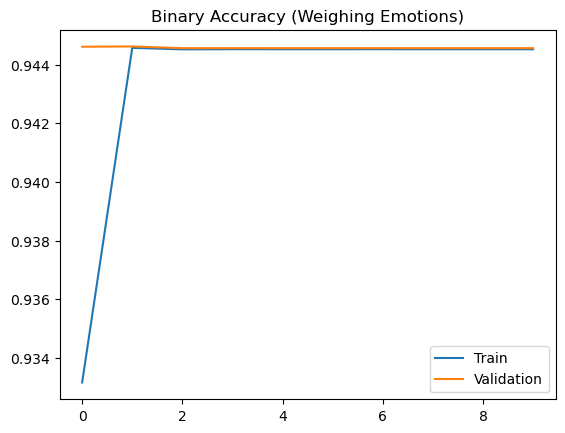

In [30]:
import matplotlib.pyplot as plt

plt.title("Binary Accuracy (Weighing Emotions)")
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

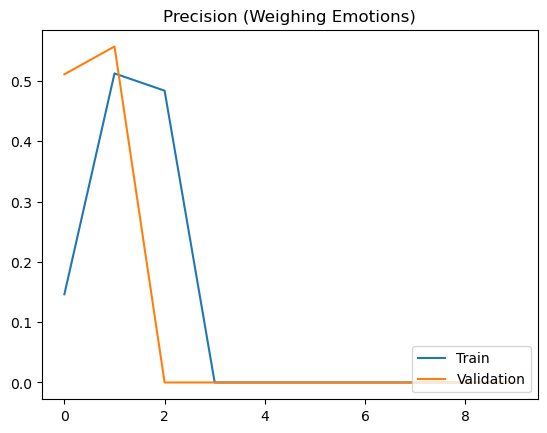

In [32]:
plt.title("Precision (Weighing Emotions)")
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

In [65]:
happiness_model.evaluate(happ_X_te, happ_y_te)

1891/1891 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - binary_accuracy: 0.9445 - loss: 0.0413 - precision: 0.0000e+00


[0.04122075438499451, 0.9445420503616333, 0.0]

### Sadness

In [33]:
sadness_model = sadness_predictor(sad_X_tr, ohe_depth)
sadness_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 713)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 18)             │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 18)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,282 (3.25 MB)

 Trainable params: 851,282 (3.25 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
sadness_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=mse_loss,
  metrics=["binary_accuracy", tf.keras.metrics.Precision()])

history = sadness_model.fit(sad_X_tr, sad_y_tr, 
                            epochs=10, 
                            validation_split=0.2, 
                            shuffle=True, 
                            batch_size=64)

Epoch 1/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - binary_accuracy: 0.8904 - loss: 0.2974 - precision_1: 0.0122 - val_binary_accuracy: 0.9693 - val_loss: 0.0470 - val_precision_1: 0.7318
Epoch 2/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - binary_accuracy: 0.9699 - loss: 0.0395 - precision_1: 0.7303 - val_binary_accuracy: 0.9700 - val_loss: 0.0283 - val_precision_1: 0.7300
Epoch 3/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 60s 20ms/step - binary_accuracy: 0.9700 - loss: 0.0272 - precision_1: 0.7301 - val_binary_accuracy: 0.9700 - val_loss: 0.0255 - val_precision_1: 0.7300
Epoch 4/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 58s 19ms/step - binary_accuracy: 0.9698 - loss: 0.0255 - precision_1: 0.7283 - val_binary_accuracy: 0.9700 - val_loss: 0.0250 - val_precision_1: 0.7300
Epoch 5/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - binary_accuracy: 0.9701 - loss: 0.0249 - precision_1: 0.7306 - val_binary_accuracy: 0.9700 - val_loss: 0.0248 - val_precision_1: 0.7300
Epoch 6/10
3025/3025 ━━━━━━━━━

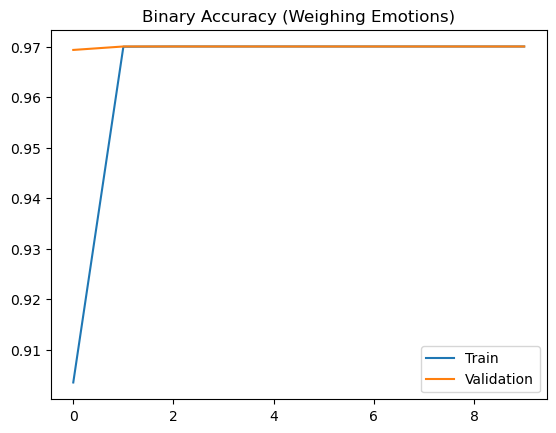

In [35]:
import matplotlib.pyplot as plt

plt.title("Binary Accuracy (Weighing Emotions)")
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

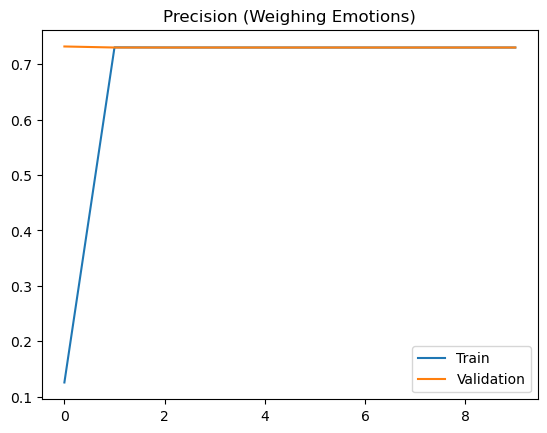

In [37]:
plt.title("Precision (Weighing Emotions)")
plt.plot(history.history["precision_1"])
plt.plot(history.history["val_precision_1"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

In [64]:
sadness_model.evaluate(sad_X_te, sad_y_te)

1891/1891 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - binary_accuracy: 0.9702 - loss: 0.0244 - precision_1: 0.7312


[0.024473970755934715, 0.9700409173965454, 0.7301238179206848]

### Anger

In [38]:
anger_model = anger_predictor(ang_X_tr, ohe_depth)
anger_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 713)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 18)             │         1,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_2 (Softmax)             │ (None, 18)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,922 (3.37 MB)

 Trainable params: 883,922 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
anger_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=mse_loss,
  metrics=["binary_accuracy", tf.keras.metrics.Precision()])

history = anger_model.fit(ang_X_tr, ang_y_tr, 
                            epochs=10, 
                            validation_split=0.2, 
                            shuffle=True, 
                            batch_size=64)

Epoch 1/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - binary_accuracy: 0.9250 - loss: 1.2059 - precision_2: 0.3249 - val_binary_accuracy: 0.9758 - val_loss: 0.0305 - val_precision_2: 0.7826
Epoch 2/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - binary_accuracy: 0.9760 - loss: 0.0270 - precision_2: 0.7850 - val_binary_accuracy: 0.9758 - val_loss: 0.0230 - val_precision_2: 0.7825
Epoch 3/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - binary_accuracy: 0.9759 - loss: 0.0226 - precision_2: 0.7832 - val_binary_accuracy: 0.9758 - val_loss: 0.0221 - val_precision_2: 0.7826
Epoch 4/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - binary_accuracy: 0.9760 - loss: 0.0220 - precision_2: 0.7836 - val_binary_accuracy: 0.9758 - val_loss: 0.0219 - val_precision_2: 0.7826
Epoch 5/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - binary_accuracy: 0.9760 - loss: 0.0218 - precision_2: 0.7842 - val_binary_accuracy: 0.9758 - val_loss: 0.0219 - val_precision_2: 0.7826
Epoch 6/10
3025/3025 ━━━━━━━━━

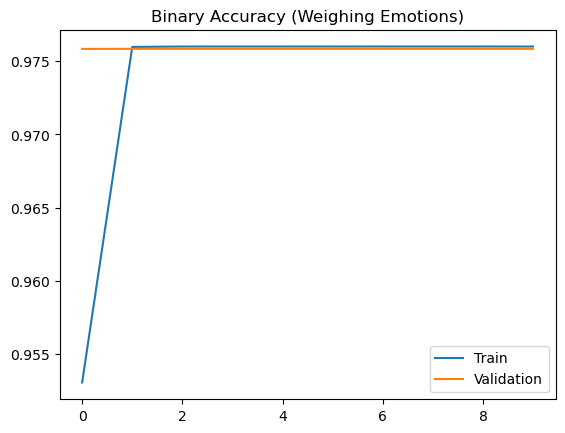

In [40]:
import matplotlib.pyplot as plt

plt.title("Binary Accuracy (Weighing Emotions)")
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

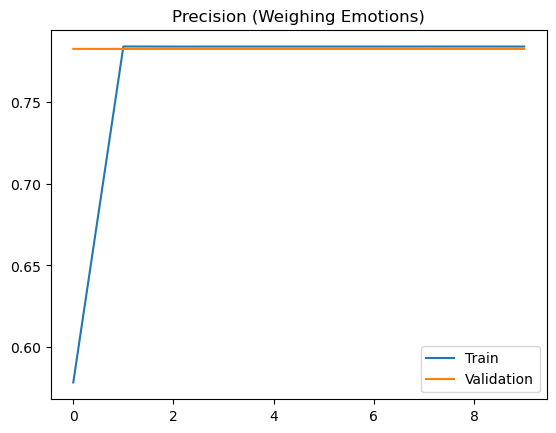

In [42]:
plt.title("Precision (Weighing Emotions)")
plt.plot(history.history["precision_2"])
plt.plot(history.history["val_precision_2"])
plt.legend(["Train", "Validation"], loc = "lower right")
plt.show()

In [63]:
anger_model.evaluate(ang_X_te, ang_y_te)

1891/1891 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - binary_accuracy: 0.9760 - loss: 0.0215 - precision_2: 0.7843


[0.021553250029683113, 0.9760064482688904, 0.7840089797973633]

In [43]:
happiness_model.save_weights("em1/hap_pred_checkpoint.weights.h5")
sadness_model.save_weights("em1/sad_pred_checkpoint.weights.h5")
anger_model.save_weights("em1/ang_pred_checkpoint.weights.h5")

## Predicting sentiment

In [46]:
sent_y_tr = preprocessing_pipeline(sent_y_tr, ohe=True, ohe_depth=ohe_depth*2)
sent_y_te = preprocessing_pipeline(sent_y_te, ohe=True, ohe_depth=ohe_depth*2)

In [49]:
import tensorflow as tf
from keras import regularizers

# Using functional model to make there be one-hot encodings for each emotion
input = tf.keras.Input(shape=(sent_X_tr.shape[1],))

regularizer = regularizers.L1L2(l1=1e-4, l2=1e-5)

x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizer)(input)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(384, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
x = tf.keras.layers.Dense(ohe_depth*2, kernel_regularizer=regularizer)(x)
x = tf.keras.activations.softmax(x)


sent_model = tf.keras.models.Model(input, x)
sent_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 713)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 384)            │       196,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 36)             │         2,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 36)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115,108 (4.25 MB)

 Trainable params: 1,115,108 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
sent_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=mse_loss,
  metrics=["binary_accuracy", tf.keras.metrics.Precision()])

sent_model.fit(sent_X_tr, sent_y_tr, epochs=10, validation_split=0.2, shuffle=True, batch_size=64)

Epoch 1/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 78s 25ms/step - binary_accuracy: 0.9680 - loss: 1.4887 - precision_5: 0.0122 - val_binary_accuracy: 0.9800 - val_loss: 0.0225 - val_precision_5: 0.3509
Epoch 2/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 71s 24ms/step - binary_accuracy: 0.9799 - loss: 0.0217 - precision_5: 0.3572 - val_binary_accuracy: 0.9800 - val_loss: 0.0206 - val_precision_5: 0.3518
Epoch 3/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step - binary_accuracy: 0.9800 - loss: 0.0205 - precision_5: 0.3460 - val_binary_accuracy: 0.9800 - val_loss: 0.0202 - val_precision_5: 0.3534
Epoch 4/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 70s 23ms/step - binary_accuracy: 0.9800 - loss: 0.0201 - precision_5: 0.3633 - val_binary_accuracy: 0.9801 - val_loss: 0.0199 - val_precision_5: 0.0000e+00
Epoch 5/10
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step - binary_accuracy: 0.9801 - loss: 0.0199 - precision_5: 0.3898 - val_binary_accuracy: 0.9801 - val_loss: 0.0197 - val_precision_5: 0.0000e+00
Epoch 6/10
3025/3025 ━

In [58]:
sent_y_te.shape

TensorShape([60490, 18])

In [61]:
sent_model.evaluate(sent_X_te, sent_y_te)

1891/1891 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - binary_accuracy: 0.9801 - loss: 0.0190 - precision_5: 0.0000e+00


[0.019036654382944107, 0.9800419211387634, 0.0]

In [66]:
sent_model.save_weights("em1/sent_pred_checkpoint.weights.h5")